# LEO 3YP - Energy Modelling Python
## MT4 - 01.11.2021

This tutorial will introduce you to basic energy balance modelling using object orientated programming in Python. Note, to run the code in the notebook, you must be using the notebook version within the OxEMF repository.

You can download the example code and data for this tutorial [here](https://bitbucket.org/scotwheeler/oxemf_3yp/).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
%matplotlib inline

# Linear Programming and Energy Balancing

Everything runs sequentially as written in the script. Clear progression and easy to develop alongside the problem. 

The code in the following sections breaks down a very basic linear energy balance analysis. Something you might consider doing for your initial high-level design.

### Import some PV data
A good place to start is to consider non-dispatchable energy generation or demand. This is energy you have no control over. 

The code below just imports an example half hourly solar profile for 1 year, storing it as the variable `solar_profile`. It also calculates and prints the total generation of the year.

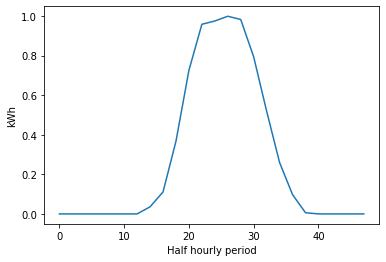

Annual Solar Generation: 3381.96 kWh


In [2]:
# import data
solar_profile = pd.read_csv("../data/solar_example.csv", usecols=[1]).values

# plot data
plt.plot(solar_profile[4752:4800])  # just plotting a single day from the entire year
plt.ylabel("kWh")
plt.xlabel("Half hourly period")
plt.show()

# calculate annual generation
print("Annual Solar Generation: {:.2f} kWh".format(solar_profile.sum()))

If we're in the UK, what capacity of solar was this data from?

### Import some load data
Traditionally, load has been considered non-dispatchable as will be treated as such here. However, flexibile demand through Demand Side Response is increasingly considered as critical to achieving net-zero energy systems.

The code below just imports an example half hourly load profile for 1 year for a typical UK domestic household, storing it as the variable `load_profile`. 

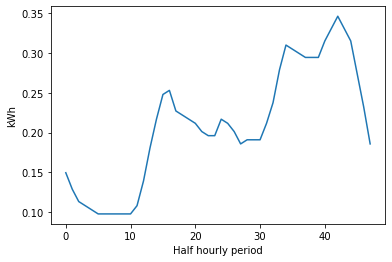

Annual Demand : 4030.00 kWh


In [3]:
# import data
load_profile = pd.read_csv("../data/load_example.csv", usecols=[1]).values

# plot data
plt.plot(load_profile[4752:4800])  # just plotting a single day from the entire year
plt.ylabel("kWh")
plt.xlabel("Half hourly period")
plt.show()

# calculate annual demand
print("Annual Demand : {:.2f} kWh".format(load_profile.sum()))

Does this annual figure sound correct for a typical UK household?

### Calculate net load

Starting to think about this as a connected system, it is helpful to first calculate the net demand. This will be useful for calculating the amount of unmet demand which needs to be imported from an external network and when it occurs. 

As a high level analysis, lets first lets look at an annual basis. As is clear from the two annual figures above, the positive number indicates we have higher demand over the entire year than what is generated by solar.

In [4]:
annual_net_demand = load_profile.sum() - solar_profile.sum()
print("Annual net demand: {:.2f} kWh".format(annual_net_demand))

Annual net demand: 648.04 kWh


Now lets consider a higher fidelity analysis, our data allows us to look at half hour resolution.

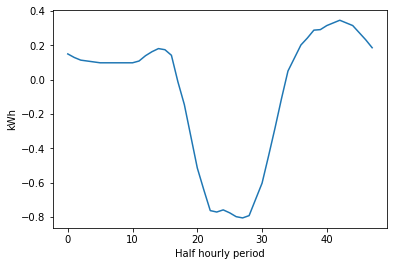

In [5]:
# calculate the net load (be careful with sign used in solar)
nondispatchable_net_load = load_profile - solar_profile

# plot graph
plt.plot(nondispatchable_net_load[4752:4800])
plt.ylabel("kWh")
plt.xlabel("Half hourly period")
plt.show()

This is a classic duck curve. It's now apparent that within the example day plotted above, there are periods where load in higher than generation (net load > 0) (early morning and evening) where energy needs to be imported, and periods where generation is higher than demand (net load < 0) (middle of the day) where energy could be exported (or stored...). 

### Calculate cost of import, export and system

Lets look in more detail at how much is being imported and exported. This can be achieved by indexing the elements which are greater than zero for required import and less than zero for export.

With this information, we can now calculate the net cost of system operation. For this example, we have used a flat rate of 15p/kWh for importing and 5p/kWh for exporting.

In [6]:
# separate import and export. Cross check annual net load.
annual_import = nondispatchable_net_load[nondispatchable_net_load>0].sum()
annual_export = nondispatchable_net_load[nondispatchable_net_load<0].sum()
annual_net =  annual_import + annual_export
print("Annual energy {:.2f} kWh".format(annual_net))

# costs with import at 15p/kWh and export at 5p/kWh
import_rate = 0.15
export_rate = 0.05
annual_cost = (annual_import * import_rate) + (annual_export * export_rate)
print("Annual cost £{:.2f}".format(annual_cost))

Annual energy 648.04 kWh
Annual cost £289.73


## Flexibility and Storage

What about flexibility and storage. How can this be integrated into the system and how will this affect the cost? Lets think about batteries.

### Code for an Ideal Battery

Below is some code for a basic battery model which charges the battery whenever there is excess generation, and discharges the battery whenever there is unmet demand. The state of charge (how much energy is stored in the battery) is tracked in `soc` and the output of battery is tracked in `outputi`. 

Finally, the new net demand of the system including battery operation is calculated as `net_demandi`. 

Go ahead and comment this code to understand what it is doing.

In [7]:
energy_capacity = 5  # kWh
power_capacity = 1.0  # kW

T = len(nondispatchable_net_load)
outputi = np.zeros((T,1))  # battery energy flow
soc = np.zeros((T,1))  # state of charge of the battery

for j in range(T):
    if j == 0:
        socval = energy_capacity
    else:
        socval = soc[j-1]
    
    # What do each of these IF statements do?
    if nondispatchable_net_load[j] > 0:        
        outputi[j] = min(power_capacity*0.5, nondispatchable_net_load[j], socval) # 0.5 to convert power to energy
        soc[j] = socval - outputi[j]
        
    elif nondispatchable_net_load[j] < 0:                                        
        outputi[j] = max(-power_capacity*0.5, nondispatchable_net_load[j],
              -(energy_capacity - socval))
        soc[j] = socval - outputi[j]
        
    elif nondispatchable_net_load[j] == 0: 
        soc[j] = socval
        
# calculate final system net load
net_loadi = nondispatchable_net_load - outputi

### Ideal Battery Operation

The code below plots the energy balance of the system with PV, load and an ideal battery for an example day.

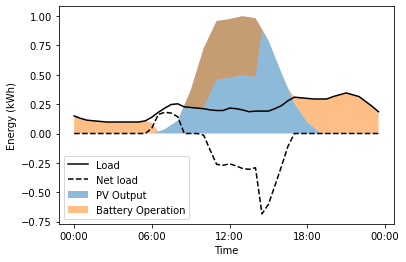

In [8]:
labels = ['PV Output', 'Battery Operation']

ax = plt.subplot(1,1,1)
p1 = plt.stackplot(np.arange(48), solar_profile[4752:4800].T, outputi[4752:4800].T, labels=labels, alpha=0.5)
p2 = plt.plot(load_profile[4752:4800], '-k', label='Load')
p3 = plt.plot(net_loadi[4752:4800], '--k', label='Net load')

plt.xticks([0,12,24,36,48])
ax.set_xticklabels(['00:00','06:00','12:00','18:00','00:00'])

plt.ylabel('Energy (kWh)', color='k')
plt.xlabel('Time', color='k')
ax.legend(loc='lower left')
plt.show()

So what's going on:
- in the morning before the sun rises at 6, the orange shaded region shows enough energy in the battery to meet the load, therefore the net load is 0. 
- between 6am and 8am, the net load increase due to the battery running out of energy, and not having sufficient solar generation to meet the load. 
- for a short period after 8am, solar generation is now greater than load and the excess can be stored in the battery, again the net load goes to 0.
- between about 10am and 2pm, the excess power generated from the solar is now greater than the power rating of the battery. Therefore some energy is stored within the battery, but some still has to be exported. Try changing the power of the battery above to see how this is affected.
- from 2pm, the battery reaches 100% state of charge, and is limited by it's energy capacity. At this point, all solar is now exported, slowly reducing until it's output falls below the load.
- from 5pm, generation is again less than demand, but the shortfall is met by the energy stored in the battery from earlier in the day. Net load again is 0. 

### Code for a Practical Battery

To increase our fidelity slightly, how might a practical battery change behaviour?

What has changed between the ideal battery and practical battery model? Describe how this is seen in the plot of state of charge.

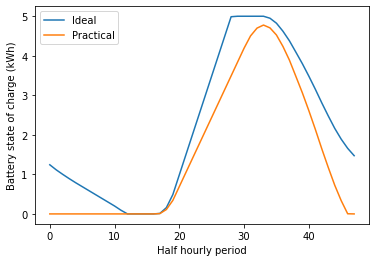

In [28]:
energy_capacity = 5                                                    # kWh
power_capacity = 1                                                       # kW
eff = 0.7

T = len(nondispatchable_net_load)
outpute = np.zeros((T,1))
soce = np.zeros((T,1))

for j in range(T):
    if j == 0:
        socval = energy_capacity
    else:
        socval = soce[j-1]

    if nondispatchable_net_load[j] > 0: 
        outpute[j] = min(power_capacity*0.5, nondispatchable_net_load[j], eff*socval)
        soce[j] = socval - (1/eff)*outpute[j]
        
    elif nondispatchable_net_load[j] < 0: 
        outpute[j] = max(-power_capacity*0.5, nondispatchable_net_load[j],
              -(1/eff)*(energy_capacity - socval))
        soce[j] = socval - eff*outpute[j]
        
    elif nondispatchable_net_load[j] == 0: 
        soce[j] = socval

# calculate final system net load
net_loade = nondispatchable_net_load - outpute
        
# plot the difference
ax = plt.subplot(1,1,1)
plt.plot(soc[4752:4800], label='Ideal')
plt.plot(soce[4752:4800], label='Practical')
plt.xlabel('Half hourly period')
plt.ylabel('Battery state of charge (kWh)')
ax.legend()
plt.show()

Things to note:
- Early morning, the state of charge of the practical battery is 0, this indicates there wasn't enough energy from the previous day to make it through the night. Why is that?
- Between 9am (18) and 3pm (30), the practical battery charges at a slower rate. This is because energy is lost during the charging process.
- Between 3pm and midnight, the practical battery discharges at a faster rate, again, this is because energy is lost due to efficiency losses, so more energy is demanded from the battery to meet the same load.
- Adjust the `eff` parameter above to see how it affects the practical battery. 

### Practical battery operation

Discuss the main difference between the plot below and above.

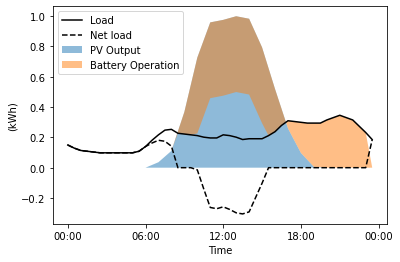

In [29]:
labels = ['PV Output', 'Battery Operation']

ax = plt.subplot(1,1,1)
p1 = plt.stackplot(np.arange(48), solar_profile[4752:4800].T, outpute[4752:4800].T, labels=labels, alpha=0.5)
p2 = plt.plot(load_profile[4752:4800], '-k', label='Load')
p3 = plt.plot(net_loade[4752:4800], '--k', label='Net load')

plt.xticks([0,12,24,36,48])
ax.set_xticklabels(['00:00','06:00','12:00','18:00','00:00'])

plt.ylabel('(kWh)', color='k')
plt.xlabel('Time', color='k')
ax.legend(loc='upper left')
plt.show()

## System costs

Lets take a look at how the inclusion of a battery affected system cost.

In [30]:
print("With no battery")
print("Annual energy {:.2f} kWh".format(annual_net))
print("Annual cost £{:.2f}".format(annual_cost))

With no battery
Annual energy 648.04 kWh
Annual cost £289.73


In [31]:
print("With Ideal Battery")
annual_import = net_loadi[net_loadi>0].sum()
annual_export = net_loadi[net_loadi<0].sum()
annual_net_i =  annual_import + annual_export
print("Annual energy {:.2f} kWh".format(annual_net_i))

# costs with import at 15p/kWh and export at 5p/kWh
annual_cost_i = (annual_import * 0.15) + (annual_export * 0.05)
print("Annual cost £{:.2f}".format(annual_cost_i))

print("A saving of £{:.2f}".format(annual_cost-annual_cost_i))

With Ideal Battery
Annual energy 643.04 kWh
Annual cost £183.41
A saving of £106.32


In [32]:
print("With Practical Battery")
annual_import = net_loade[net_loade>0].sum()
annual_export = net_loade[net_loade<0].sum()
annual_net_e =  annual_import + annual_export
print("Annual energy {:.2f} kWh".format(annual_net_e))

# costs with import at 15p/kWh and export at 5p/kWh
annual_cost_e = (annual_import * 0.15) + (annual_export * 0.05)
print("Annual cost £{:.2f}".format(annual_cost_e))

print("A saving of £{:.2f}".format(annual_cost-annual_cost_e))

With Practical Battery
Annual energy 1392.05 kWh
Annual cost £254.76
A saving of £34.97


Things to explore on your own:

- Having a lower efficeincy in your battery
- Vary the battery capacity between 1 - 10 kWh
- Vary the power capacity between 0.1 - 1 kW
- How does this stack up against the cost of a typical home battery system? What is the payback time?

# Object Orientated Programming

However, as your system grows, you might find there is a lot of repeated concepts; how do you easily scale your code?

Object orientated programming allows you to write code which has particular properties or carries out particular functions which are common to like objects. Multiple instances of those objects can then be created without reproducing the code, with the knowledge that like objects will behave in the same way. Through an objects public methods, objects (of the same or different types) can interact with each other.

For an online introduction to Object Orientated Programming in Python, look [here](https://realpython.com/python3-object-oriented-programming/) or [here](https://www.datacamp.com/community/tutorials/python-oop-tutorial).

### OOP four principles

The four principles of object-oriented programming are encapsulation, abstraction, inheritance, and polymorphism. For a good blog explaining these concepts, look [here](https://www.freecodecamp.org/news/object-oriented-programming-concepts-21bb035f7260/). 

Below is my summary of how these are dealt with in python:

**Encapsulation** in Python is through the Class functionality used to define objects. A Class can be thought of as a blueprint for common properties and methods of an object. An object is a single instance of a class.

**Abstraction** is achieved through public and private methods, although this isn't strict in python. All methods are defined with the `def` statement. Private methods and variables are identified using underscores, a single underscore is just convention as a flag to another programmer, double underscores are somewhat stricter and protect against accidental manipulation.

**Inheritance** occurs through parent and child classes. The functionality of a parent class can be inherited by a child when it is created by providing the parent class as an argument to the child class definition e.g. `class Child(Parent)`. `super()` can be used to call the superclass's methods.

**Polymorphism** allows operators to be used in different scenarios and like objects to be iterated over. This can be achieved by defining common methods across like objects. This can be achieved through inheritance; specific functionality can be implemented with Method Overiding. The `getOutput` method below is an example of this.

Be sure to properly understand syntax like `__init__`, `class`, `def` and `self` etc. You can use Spyder to investigate the `.py` files in more detail to learn what you are importing. 

&nbsp;

[Here](https://micropyramid.com/blog/understand-self-and-__init__-method-in-python-class/) is a good starting point to understand classes in Python.


## EPG's Energy Management Framework

The example code used in the next section of this tutorial is based on a simplified version of EPG's Open Platform for Energy Networks (OPEN), the paper with a full description of modelling framework can be found [here](https://www.sciencedirect.com/science/article/pii/S0306261920309090#f0010) and associated documentation [here](https://open-platform-for-energy-networks.readthedocs.io/en/latest/).

The code is available on [GitHub](https://github.com/EPGOxford/OPEN).

&nbsp;

OPEN's universal modelling language (UML) class diagram:

<img src="https://raw.githubusercontent.com/EPGOxford/OPEN/master/docs/_imgs/OPEN_UML_5_flat.svg" />

The 3YP OxEMF version has 3 basic versions of the following modules:
- Assets
- Market
- Energy System

## Example code and data


You can download the example code and data [here](https://bitbucket.org/scotwheeler/oxemf_3yp/). The OxEMF package includes 4 Python files (the 3 modules: Assets, EnergySystem and Market, and a main script file to setup and run the whole system) and a folder containing example data:

1. Assets.py
2. EnergySystem.py
3. Market.py
4. 3YP_main.py
5. /data folder

Parts of the code are reproduced below to demonstrate some of the key concepts. 

First lets import the 3 modules from the OxEMF package. This is done in the same way as importing other familiar libraries such as numpy or pandas. Be careful to ensure you are in the folder above the OxEMF package folder. You will need to change the directory depending on where you downloaded the repository to. 

In [14]:
os.chdir("/Users/scotwheeler/Documents/repos/leo_3yp_2020/")  # set working directory to main folder, one folder above where this notebook is stored

# import modules from OxEMF package
from OxEMF import Assets as AS
from OxEMF import EnergySystem as ES      
import OxEMF.Market as MK

os.chdir("OxEMF/")  # change directory into the OxEMF package to allow code to import data from the sub-folder.

# define some global time variables based on the known resolution of the example data.
dt = 30/60  # 30 minute time intervals
T = int((24*365)/dt) # Number of intervals

## Class example

The code below is an example of parent (Non-Dispatchable) and child (pvAsset) object definitions.

Some things to note:
- The `__init__` constructor method initializes core attributes of the class. Look how variables are passed through the `__init__` method. `__init__` can also run methods, such as `self.load_profile()` in pvAsset, as part of the initialization. 
- Look how the child class (pvAsset) inherits from the parent (Non-dispatchable) class `Class pvAsset(Non-Dispatchable):`; it also runs the constructor method from it's parent as it initializes itself using `super().__init__()`.
- the `getOutput()` method is one which needs to exist for all asset types and will be called by other methods within the EnergySystem and Market modules. However, the code which is executed by `getOutput()` will be specific to each asset type and is an example of polymorphism.
- note how doc strings, defined using 3 quotes `""" Doc string """` are used within each method. These can be used at a later date to automatically generate documentation. Look [here](https://oxemf-3yp.readthedocs.io/) at the documentation automatically generated for this package.


In [15]:
class Non_Dispatchable:
    """Non-dispatchable asset base class"""
    def __init__(self):
        self.dispatch_type = "Non-dispatchable"
        self.capacity = 0
        self.install_cost = 0
        self.lifetime = 20
        self.genFiT = 0
        

class pvAsset(Non_Dispatchable):
    """
    PV asset class

    Parameters
    ----------
    profile_filepath : str
            Filepath for the profile
    
    Capacity : float
        PV capacity, kW.

    install_cost : float
        £ price per kWp to install
        
    maintenance_cost : float
        Annual maintenance cost in £s
    """
    def __init__(self, profile_filepath, capacity, install_cost=1500,
                 maintenance=0, **kwargs):
        super().__init__()
        self.profile_filepath = profile_filepath
        self.capacity = capacity
        self.asset_type = 'PV'
        self.install_cost = install_cost * 100  # p/kWp
        self.maintenance = maintenance  # per year
        self.genFiT = 0.05  # p/kWh
        self.cf = self.loadProfile()
        
    def loadProfile(self):
        """
        Loads the kW/kWp hourly solar profile

        Returns
        -------
        kW/kWp solar profile

        """
        df = pd.read_csv(self.profile_filepath, index_col=0,
                         parse_dates=True)  # kW/kWp
        
        return df
        

    def getOutput(self, dt):
        """
        Return PV output

        Input
        -----
        dt : float
            Time interval (hours)

        Returns
        -------
        PV output : numpy array
        """
        cfHH = self.cf.resample('0.5H').mean()
        # adding a missing point at the end
        cfHH = cfHH.append(pd.DataFrame({cfHH.columns[0]: np.nan},
                                      index=[(cfHH.index[-1] +
                                              timedelta(minutes=30))]))
        cfHH = cfHH.interpolate()
        
        output = cfHH.values * self.capacity * dt  # kWh
        self.output = output
        return output


## Defining the assets

Now lets use these objects to setup the assets of our energy system. To initialize an object, the class can be accessed via dot notation via the Asset module, in the case of a PV asset: `pv_asset = AS.pvAsset(capacity)`. 

In the example below, notice how we loop over a list of PV capacities and battery parameters to initialize multiple objects of those types. These are then stored within the lists `non_dispatchable` and `dispatchable`.

The load object has been designed for a group of houses, rather than a single house. As such, the example load profile it uses is an aggregate for class 1 domestic meters produced by Elexon. A single house profile would be much more variable. You could try improving this, or creating a new object, appropriate for a single household. However, be sure to include a random element (or pick from multiple single profile examples) so you don't end up with every household having the same, peaky demand profile.

In [16]:
dispatchable = []
non_dispatchable = []
all_assets = []
pv_sites = []

# PV source
# 3 PV installations
pv_capacities = [2,5,15]  # kW
for pv_cap in pv_capacities:
    pv_site = AS.pvAsset(pv_cap)
    pv_sites.append(pv_site)
    non_dispatchable.append(pv_site)

# Load
# 1 group of 10 households
nHouses = 10
load_site1 = AS.loadAsset(nHouses)
non_dispatchable.append(load_site1)

# Battery
# 5 small rapid batteries, 1 larger slower battery
battery_capacities = [2.5]*5 + [1000]  #kWh
battery_powers = [1]*5 + [5]  # kW
for cap, power in zip(battery_capacities, battery_powers):
    battery_site = AS.PracticalBatteryAsset(cap, power, dt, T, eff=0.9)
    dispatchable.append(battery_site)
    
all_assets = non_dispatchable + dispatchable

The graph below demonstrates how to iterate over object instance, calling the getOutput function to retrieve the generation profile and the apacity parameter for the legend label. Both exist for each object, but their values are unique to that instance of the object. Printing the type is just included to demonstrate how each element of the list is an instance of the pvAsset class.

<class 'OxEMF.Assets.pvAsset'>
<class 'OxEMF.Assets.pvAsset'>
<class 'OxEMF.Assets.pvAsset'>


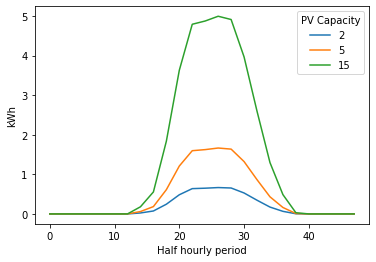

In [17]:
for site in pv_sites:
    print(type(site))
    plt.plot(site.getOutput(dt)[4752:4800], label=site.capacity)
    
plt.ylabel("kWh")
plt.xlabel("Half hourly period")
plt.legend(title='PV Capacity')
plt.show()

## Creating an Energy System

We're now going to associate our separate asset objects with an Energy System. The Energy System is treated as another object and is defined, with the code reproduced below for reference, in the EnergySystem module which was imported earlier. Notice that it takes two lists of dispatchable and non-dispatchable asset objects (along with the dt and T variables defined earlier). 

For this basic example, it has just one function, `basic_energy_balance()`. This function first calculates the net load for non-dispatchable assets, then deploys the non-dispatchable assets (in the order they appear in the dispatchable list). Think how you might split this process into multiple methods. Finally, the over net load after the dispatchable assets have been deployed is returned.

During this dispatchable deployment, the assets `getOutput()` function is called, however, unlike a non-dispatchable asset which just returns a set profile, the `getOutput()` method of a dispatchable asset models how the asset gets dispatched as per the battery code presented earlier in this tutorial. Hence why `surplus` is passed as an argument in this case.

Think about the limitations of this basic approach to deploying dispatchable assets and how you could improve this. 

In [18]:
class EnergySystem:
    """
    Base Energy System class

    Input
    -----
    nondispat : list
        List of non-dispatchable asset objects

    dispat : list
        List of dispatchable assets. The order of which determines control
        strategy in basic energy balance.

    dt : float
        time step

    T : float
        Number of time intervals
    """

    def __init__(self, nondispat, dispat, dt, T):
        self.nondispat = nondispat
        self.dispat = dispat
        self.assets = nondispat + dispat
        self.dt = dt  # time interval duration
        self.T = T  # number of time intervals

    def basic_energy_balance(self):
        """
        Basic energy system balancing. Dispatchable assets are deployed in
        order defined by list.

        Returns
        -------

        net_load : Array
            The net load of the system.
        """
        nondispat = self.nondispat  # nondispatcable asset list
        dispat = self.dispat  # dispatchable asset list

        # sum non-dispatchable assets
        net_nondis = np.zeros((self.T, 1))
        for i, asset in enumerate(nondispat):
            if asset.asset_type == 'DOMESTIC_LOAD':
                profile = nondispat[i].getOutput(self.dt)
            elif asset.asset_type == 'PV':
                profile = -1 * nondispat[i].getOutput(self.dt)  # might want -1 inside asset

            net_nondis += profile

        self.non_disp_load = net_nondis
        net_load = net_nondis

        # deploy dispatchable gen
        for i, asset in enumerate(dispat):
            surplus = net_load
            profile = asset.getOutput(surplus)
            net_load = surplus - profile

        self.net_load = net_load
        self.disp_load = net_load - net_nondis

        return net_load

The code below demonstrates how the energy system instance is initialized and a basic energy balance is carried out to determine the final net load. The resulting net load is then plotted. Try changing the size and number of assets above, then rerunning the code below to see the affect on the final net load of the energy system.

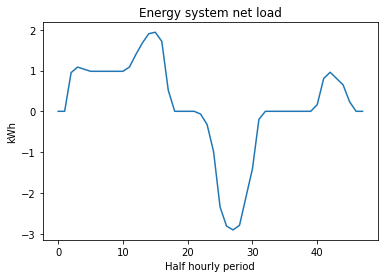

Net system load: 16265.72 kWh
Positive indicates more demand than generation annually


In [19]:
# set up an Energy System
energy_system = ES.EnergySystem(non_dispatchable, dispatchable, dt, T)
# run a basic energy balance
net_load = energy_system.basic_energy_balance()

plt.plot(net_load[4752:4800])
plt.ylabel("kWh")
plt.xlabel("Half hourly period")
plt.title("Energy system net load")
plt.show()

print("Net system load: {:.2f} kWh".format(net_load.sum()))
print("Positive indicates more demand than generation annually")

The code below plots a detailed stackplot of the energy balance for each asset group.

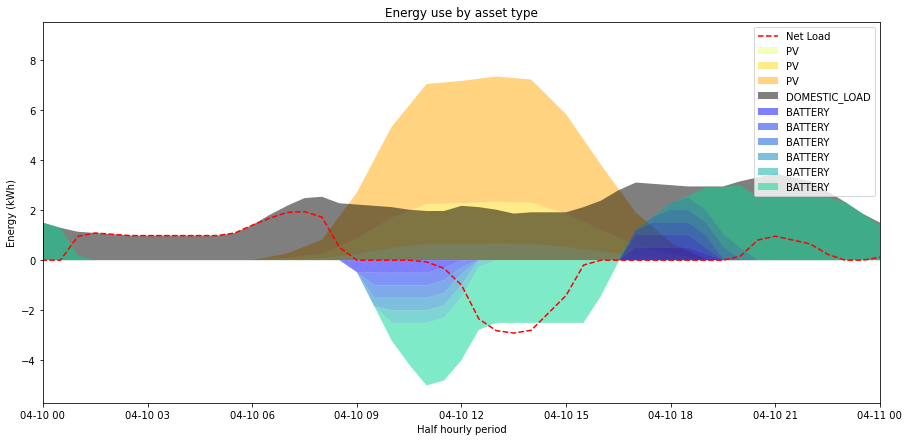

In [20]:
date_index = pd.date_range(start=datetime.datetime(2017,1,1), end=datetime.datetime(2017,12,31,23,59,59), freq='0.5H')

all_asset_types = [asset.asset_type for asset in all_assets]

# asset_type list [[PV],[DOMESTIC_LOAD], [BATTERY]]
assets_by_type = [[],[],[]]
asset_types = [[],[],[]]
asset_colours = [[],[],[]]
for asset in all_assets:
    if asset.asset_type == 'PV':
        assets_by_type[0].append(asset)
        asset_types[0].append('PV')
    if asset.asset_type == 'DOMESTIC_LOAD':
        assets_by_type[1].append(asset)
        asset_types[1].append('DOMESTIC_LOAD')
    if asset.asset_type in ['IDEAL BATTERY', 'PRACTICAL BATTERY']:
        assets_by_type[2].append(asset)
        asset_types[2].append('BATTERY')

pv_colourmap = cm.get_cmap("Wistia")
load_colourmap = cm.get_cmap('copper')
bat_colourmap = cm.get_cmap('winter')
asset_colours[0] = pv_colourmap(range(0,256,int(np.ceil(256/len(assets_by_type[0])))))
asset_colours[1] = load_colourmap(range(0,256,int(np.ceil(256/len(assets_by_type[1])))))
asset_colours[2] = bat_colourmap(range(0,256,int(np.ceil(256/len(assets_by_type[2])))))


# plot breakdown of asset contribution to net load
fig, ax1 = plt.subplots(figsize=(15,7))
for asset_group, colours, types in zip(assets_by_type, asset_colours, asset_types):
    asset_outputs = np.array([asset.output.flatten() for asset in asset_group])
    ax1.stackplot(date_index, asset_outputs, colors=colours, alpha=0.5, labels=types)

ax1.plot(date_index,net_load, '--r', label='Net Load')
ax1.set_ylabel("Energy (kWh)")
ax1.set_xlabel("Half hourly period")
ax1.set_title("Energy use by asset type")
ax1.set_xlim((datetime.datetime(2017,4,10), datetime.datetime(2017,4,11)))
ax1.legend()
plt.show()

Finally, lets provide a financial model for our energy system. This is done through the `marketObject` in the Market module. The market object uses the Market Inbalance Price for 2017, published by national grid, as a variable import tariff proxy. A flat export price can be set via the `export_rate` parameter, and the additional Feed-in-tariff price is set within the asset.

The market object has a number of functions for calculating different prices, these are:
- `getGridCost`: this is a profile of import and export costs
- `getFiTGenCost`: this is a profile of the bonus FiT contribution
- `getInstallCost`: this provides the total install cost, and the annual cost of install based on the lifetime of the asset. 
- `getTotalCost`: this provides the annual total system cost and is the sum of grid cost, FiT cost and annual install cost.
- `gridBreakdown`: this provides separate import and export payment profiles

How could you use these to calculate payback time of a battery investment?

In [21]:
## Integrating a market
market1 = MK.marketObject(energy_system, export_rate=5.24)
# run
opCost = market1.getTotalCost()
grid_cost = market1.getGridCost().sum()
print('Annual network cost: £ %.2f' % (grid_cost / 100))

purchased, sold = market1.gridBreakdown()

purchased_daily = ES.E_to_dailyE(purchased, dt) / 100 # convert to £s
sold_daily = ES.E_to_dailyE(sold, dt) / 100 # convert to £s

Annual network cost: £ 2732.58


The plot below shows the daily import and export payments over the course of the whole year.

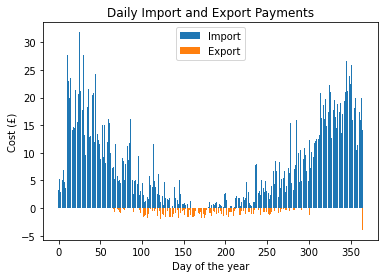

In [22]:
ax = plt.subplot(1,1,1)
p1 = plt.bar(range(365), purchased_daily, label="Import")
p2 = plt.bar(range(365), sold_daily, label="Export")
plt.xlabel("Day of the year")
plt.ylabel("Cost (£)")
plt.legend()
plt.title("Daily Import and Export Payments")
plt.show()

For a clean version:

Link to [Notebook 2](LEO_3YP_OxEMF_Example.ipynb) or look at file `3YP_main.py`

## To think about...

- What types of dispatchable and non-dispatchable assets are relevant to your project.
- Start creating asset classes for each of these. Only needs to be simple model for operation at this stage.
- What data is important for modelling your energy system?